<a href="https://colab.research.google.com/github/atsss/Deep-Learning-for-Computer-Vision-with-Python-and-TensorFlow/blob/main/Human_Emotions_Detection_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data download


> https://gemini.google.com/app/de3364032c27214c



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:02<00:00, 111MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [2]:
!pwd

/content


In [3]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/

In [4]:
!mv /content/4 /content/dataset

## Define variables

In [22]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image

In [23]:
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [24]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [25]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## Dataset Loading

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


## Data Agumentation

In [31]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [30]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [32]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

## Transfer Learning with EfficientNet

In [11]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
backbone.trainable = False

In [13]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

## Training

In [16]:
loss_function = CategoricalCrossentropy()

In [17]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [18]:
pretrained_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [33]:
history = pretrained_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
    )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 70s 327ms/step - accuracy: 0.8659 - loss: 0.3398 - top_k_accuracy: 0.9748 - val_accuracy: 0.8297 - val_loss: 0.5405 - val_top_k_accuracy: 0.9508
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step - accuracy: 0.8837 - loss: 0.3009 - top_k_accuracy: 0.9748 - val_accuracy: 0.8266 - val_loss: 0.5386 - val_top_k_accuracy: 0.9442
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 308ms/step - accuracy: 0.8852 - loss: 0.2807 - top_k_accuracy: 0.9768 - val_accuracy: 0.8314 - val_loss: 0.5026 - val_top_k_accuracy: 0.9539
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 315ms/step - accuracy: 0.8960 - loss: 0.2533 - top_k_accuracy: 0.9790 - val_accuracy: 0.8323 - val_loss: 0.5313 - val_top_k_accuracy: 0.9491
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 82s 318ms/step - accuracy: 0.9003 - loss: 0.2368 - top_k_accuracy: 0.9832 - val_accuracy: 0.8354 - val_loss: 0.5000 - val_top_k_accuracy: 0.9583
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 68s 318ms/step - accuracy: 0.9109 -

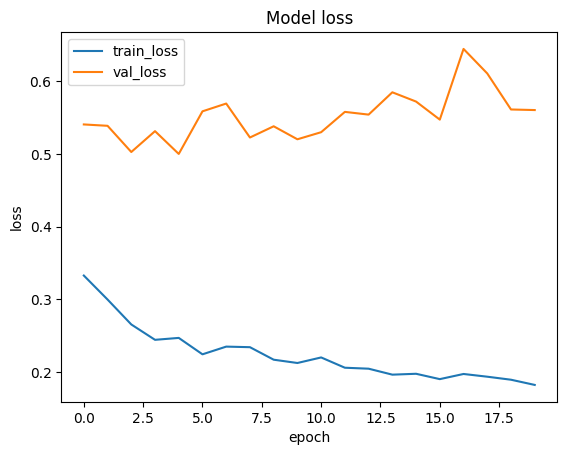

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

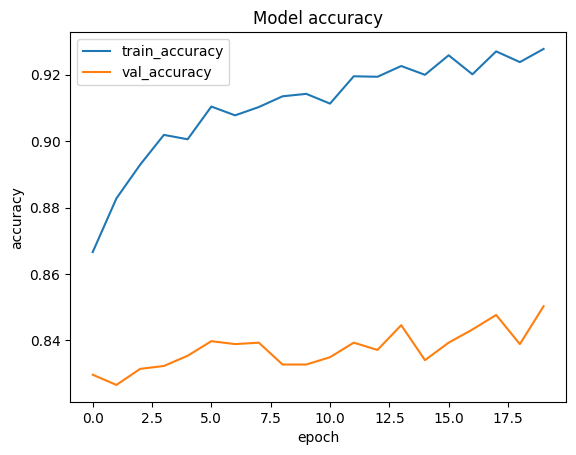

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [36]:
pretrained_model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8462 - loss: 0.5720 - top_k_accuracy: 0.9498


[0.5602908134460449, 0.850307285785675, 0.9521510004997253]